Regression feedforward network

In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd
import os
import numpy as np

In [2]:
FILE = './data/housing.csv'
df = pd.read_csv(FILE, header=None, delim_whitespace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get x, y train / val / test
X, Y = df.iloc[:,:-1], df.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, random_state=42, test_size=33)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=True, random_state=42, test_size=20)

# Initate Scaler
scaler_x, scaler_y = MinMaxScaler(), MinMaxScaler()
scaler_x.fit(x_train)
scaler_y.fit(y_train.values.reshape(-1, 1))

model_settings = {
    'input_size': x_train.shape[1],  # n_features
    'hidden_size_1': 32,
    'hidden_size_2': 16,
    'output_size': 1,
}

# Hyper-parameters 
num_epochs = 30
batch_size = 8
learning_rate = 0.001


In [4]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
 
  def __init__(self,x, y, scaler_x, scaler_y):
    self.x_train=torch.tensor(scaler_x.transform(x.values), dtype=torch.float32)
    self.y_train=torch.tensor(scaler_y.transform(y.values.reshape(-1, 1)), dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [5]:
from torch.utils.data import DataLoader
torch.manual_seed(1)

train_dataset = MyDataset(x_train, y_train, scaler_x, scaler_y)
val_dataset = MyDataset(x_val, y_val, scaler_x, scaler_y)
test_dataset = MyDataset(x_test, y_test, scaler_x, scaler_y)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=True)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=True)

In [6]:
class HousePredictor(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, early_stop_count=3):
        super(HousePredictor, self).__init__()
        # Input
        self.input_size = input_size
        self.input_layer = nn.Linear(input_size, hidden_size_1)
        # Activiation
        self.relu = nn.ReLU()
        # Hidden Layers
        self.l1 = nn.Linear(hidden_size_1, hidden_size_2)
        # Output
        self.output = nn.Linear(hidden_size_2, output_size)
        # Dropout
        self.dropout = nn.Dropout()
        # Early stop
        self.eval_loss = None
        self.early_stop_count = early_stop_count
        self.stop_counter = 0

    def forward(self, input):
        out = self.input_layer(input)
        out = self.relu(out)
        out = self.l1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        return self.output(out)
    
    @staticmethod
    def optimizer_step(optimizer, loss):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def get_loss(self, x, y, criterion):
        features = x.to(device)
        y = y.to(device)
        outputs = self(features)
        loss = criterion(outputs, y)

        return loss

    def update_eval(self, eval_loss):
        if not self.eval_loss:
            self.eval_loss = eval_loss
        elif eval_loss < self.eval_loss:
            self.stop_counter = 0
            self.eval_loss = eval_loss
            torch.save(self.state_dict(), os.path.join('./data/torch_models/', 'best_regression.pth'))
        else:
            self.stop_counter += 1
    
    @property
    def early_stop(self):
        return self.stop_counter >= self.early_stop_count
    

In [7]:
model = HousePredictor(**model_settings).to(device)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
n_total_steps = len(x_train) / batch_size

losses, val_losses = [], []

for epoch in range(1, num_epochs +1):
    e_loss, e_val_loss = [], []
    for i, (x, y) in enumerate(train_loader, 1):
        model.train()

        # Forward pass
        loss = model.get_loss(x, y, criterion)
        e_loss.append(loss.item())

        # Backward and optimize
        model.optimizer_step(optimizer, loss)

        if (i) % 10 == 0:
            print (f'Epoch [{epoch}/{num_epochs}], Step [{i}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    for i, (x_val, y_val) in enumerate(val_loader):
        model.eval()
        
        loss = model.get_loss(x_val, y_val, criterion)
        e_val_loss.append(loss.item())

    val_loss = sum(e_val_loss) / len(e_val_loss)
    
    # Update with latest validation loss
    model.update_eval(val_loss)

    val_losses.append(val_loss)
    losses.append(sum(e_loss) / len(e_loss))
    
    if model.early_stop:
        print(f'No increase in validation loss since epoch {epoch - model.early_stop_count}\nStopping Traing')
        break



Epoch [1/30], Step [10/56.625], Loss: 0.1605
Epoch [1/30], Step [20/56.625], Loss: 0.0236
Epoch [1/30], Step [30/56.625], Loss: 0.0196
Epoch [1/30], Step [40/56.625], Loss: 0.0766
Epoch [1/30], Step [50/56.625], Loss: 0.0266
Epoch [2/30], Step [10/56.625], Loss: 0.0813
Epoch [2/30], Step [20/56.625], Loss: 0.0074
Epoch [2/30], Step [30/56.625], Loss: 0.0546
Epoch [2/30], Step [40/56.625], Loss: 0.0097
Epoch [2/30], Step [50/56.625], Loss: 0.1604
Epoch [3/30], Step [10/56.625], Loss: 0.0192
Epoch [3/30], Step [20/56.625], Loss: 0.0898
Epoch [3/30], Step [30/56.625], Loss: 0.0464
Epoch [3/30], Step [40/56.625], Loss: 0.0286
Epoch [3/30], Step [50/56.625], Loss: 0.0315
Epoch [4/30], Step [10/56.625], Loss: 0.0453
Epoch [4/30], Step [20/56.625], Loss: 0.0390
Epoch [4/30], Step [30/56.625], Loss: 0.0049
Epoch [4/30], Step [40/56.625], Loss: 0.0234
Epoch [4/30], Step [50/56.625], Loss: 0.0102
Epoch [5/30], Step [10/56.625], Loss: 0.0063
Epoch [5/30], Step [20/56.625], Loss: 0.0344
Epoch [5/3

<AxesSubplot:>

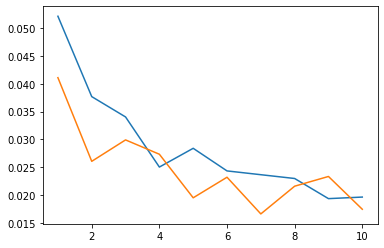

In [10]:
sns.lineplot(x=range(1, len(losses) + 1), y=losses)
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses)

In [11]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    
    model = HousePredictor(**model_settings).to(device)
    model.load_state_dict(torch.load('data/torch_models/best_regression.pth'))
    model.eval()
    vals =  []
 
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        
        for v in outputs.data:
            vals.append(v.tolist())

In [12]:
vals = scaler_y.inverse_transform(np.array(vals).reshape(-1, 1))

<AxesSubplot:>

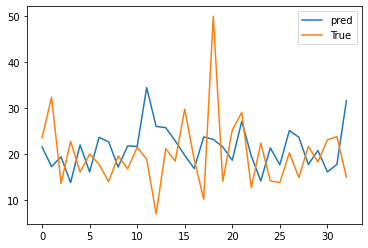

In [13]:
sns.lineplot(x=range(len(vals)), y=vals.flatten(), label='pred')
sns.lineplot(x=range(len(y_test)), y=y_test.values, label='True')